# CNN Training + Testing

In [ ]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [ ]:
#defining constants
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [ ]:
#preparing training data
filenames = os.listdir("training_set/training_set")
# print(filenames)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

df['category'].value_counts().plot.bar()

In [4]:
#building model
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

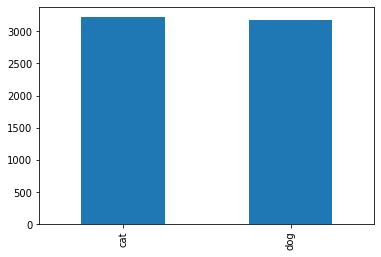

In [5]:
#early stop
earlystop = EarlyStopping(patience=10)

#learning rate rduction
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

#preparing data
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})

train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

train_df['category'].value_counts().plot.bar()

validate_df['category'].value_counts().plot.bar()

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [6]:
#training generator
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "training_set/training_set", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

#validation generator
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./training_set/training_set", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 6404 validated image filenames belonging to 2 classes.
Found 1601 validated image filenames belonging to 2 classes.


Found 1 validated image filenames belonging to 1 classes.


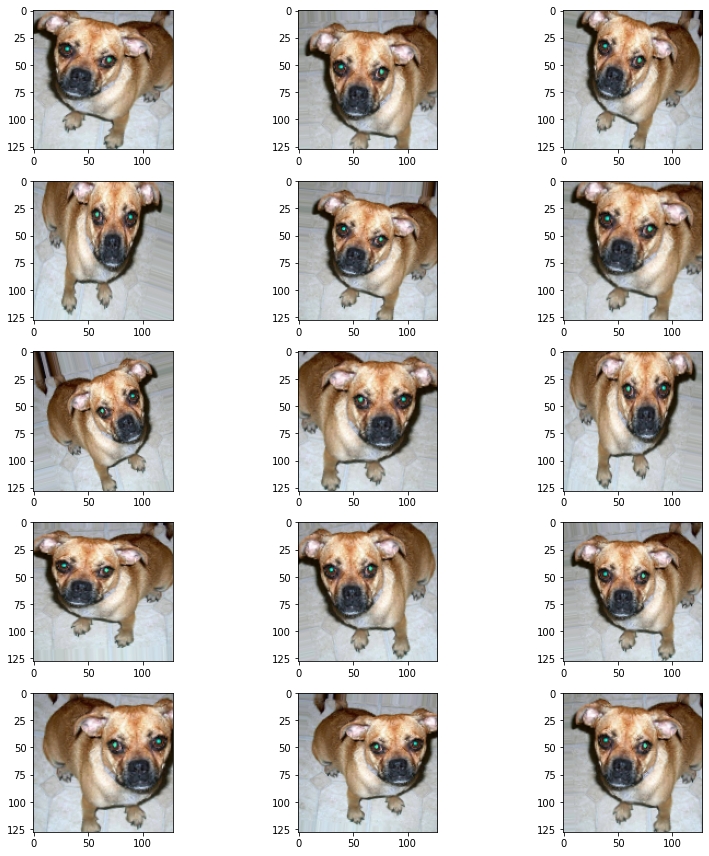

In [7]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "./training_set/training_set", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [ ]:
#fit model
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

model.save_weights("model.h5")

/home/danie_techie/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
426/426 [==============================] - 260s 606ms/step - loss: 1.2040 - accuracy: 0.5540 - val_loss: 0.7094 - val_accuracy: 0.6031
Epoch 2/50
426/426 [==============================] - 244s 573ms/step - loss: 0.7044 - accuracy: 0.6288 - val_loss: 0.7304 - val_accuracy: 0.6258
Epoch 3/50
426/426 [==============================] - 213s 500ms/step - loss: 0.6283 - accuracy: 0.6602 - val_loss: 0.6059 - val_accuracy: 0.6899
Epoch 4/50
426/426 [==============================] - 204s 479ms/step - loss: 0.5914 - accuracy: 0.6966 - val_loss: 0.5607 - val_accuracy: 0.7208
Epoch 5/50
426/426 [==============================] - 218s 512ms/step - loss: 0.5463 - accuracy: 0.7311 - val_loss: 0.9169 - val_accuracy: 0.6189
Epoch 6/50
426/426 [==============================] - 222s 520ms/step - loss: 0.5334 - accuracy: 0.7437 - val_loss: 1.1294 - val_accuracy: 0.5881
Epoch 7/50
426/426 [==============================] - 217s 509ms/step - loss: 0.5234 - accuracy: 0.7415 - val_loss: 0.5188 -

Epoch 29/50
426/426 [==============================] - 249s 586ms/step - loss: 0.3587 - accuracy: 0.8441 - val_loss: 0.4479 - val_accuracy: 0.7824
Epoch 30/50
426/426 [==============================] - 247s 579ms/step - loss: 0.3479 - accuracy: 0.8473 - val_loss: 0.3331 - val_accuracy: 0.8642
Epoch 31/50
426/426 [==============================] - 249s 585ms/step - loss: 0.3663 - accuracy: 0.8388 - val_loss: 0.3834 - val_accuracy: 0.8358
Epoch 32/50
426/426 [==============================] - 239s 562ms/step - loss: 0.3505 - accuracy: 0.8533 - val_loss: 0.4225 - val_accuracy: 0.8270
Epoch 33/50
426/426 [==============================] - 236s 555ms/step - loss: 0.3347 - accuracy: 0.8626 - val_loss: 0.3784 - val_accuracy: 0.8591
Epoch 34/50
426/426 [==============================] - 240s 562ms/step - loss: 0.3218 - accuracy: 0.8681 - val_loss: 0.4115 - val_accuracy: 0.8226
Epoch 35/50
426/426 [==============================] - 226s 529ms/step - loss: 0.3247 - accuracy: 0.8618 - val_loss: 0

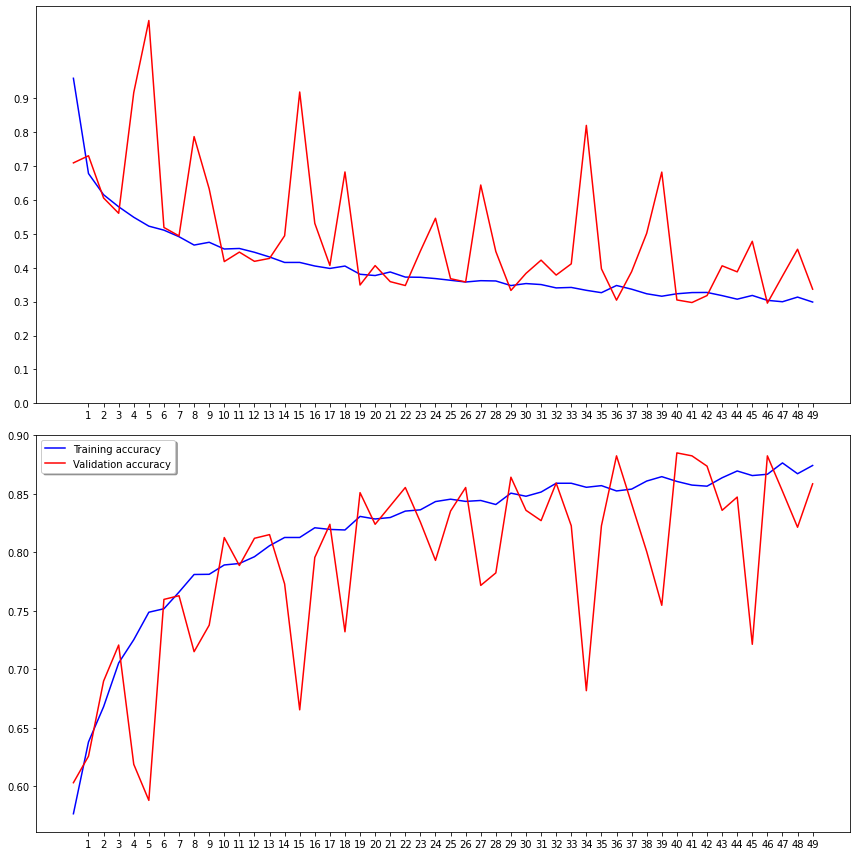

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Testing Data

In [15]:
test_filenames = os.listdir("test_set/test_set")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "test_set/test_set", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 2023 validated image filenames.


<AxesSubplot:>

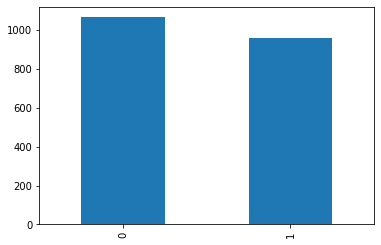

In [20]:
#predict
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))
test_df['category'] = np.argmax(predict, axis=-1)

label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

#virtual result
test_df['category'].value_counts().plot.bar()

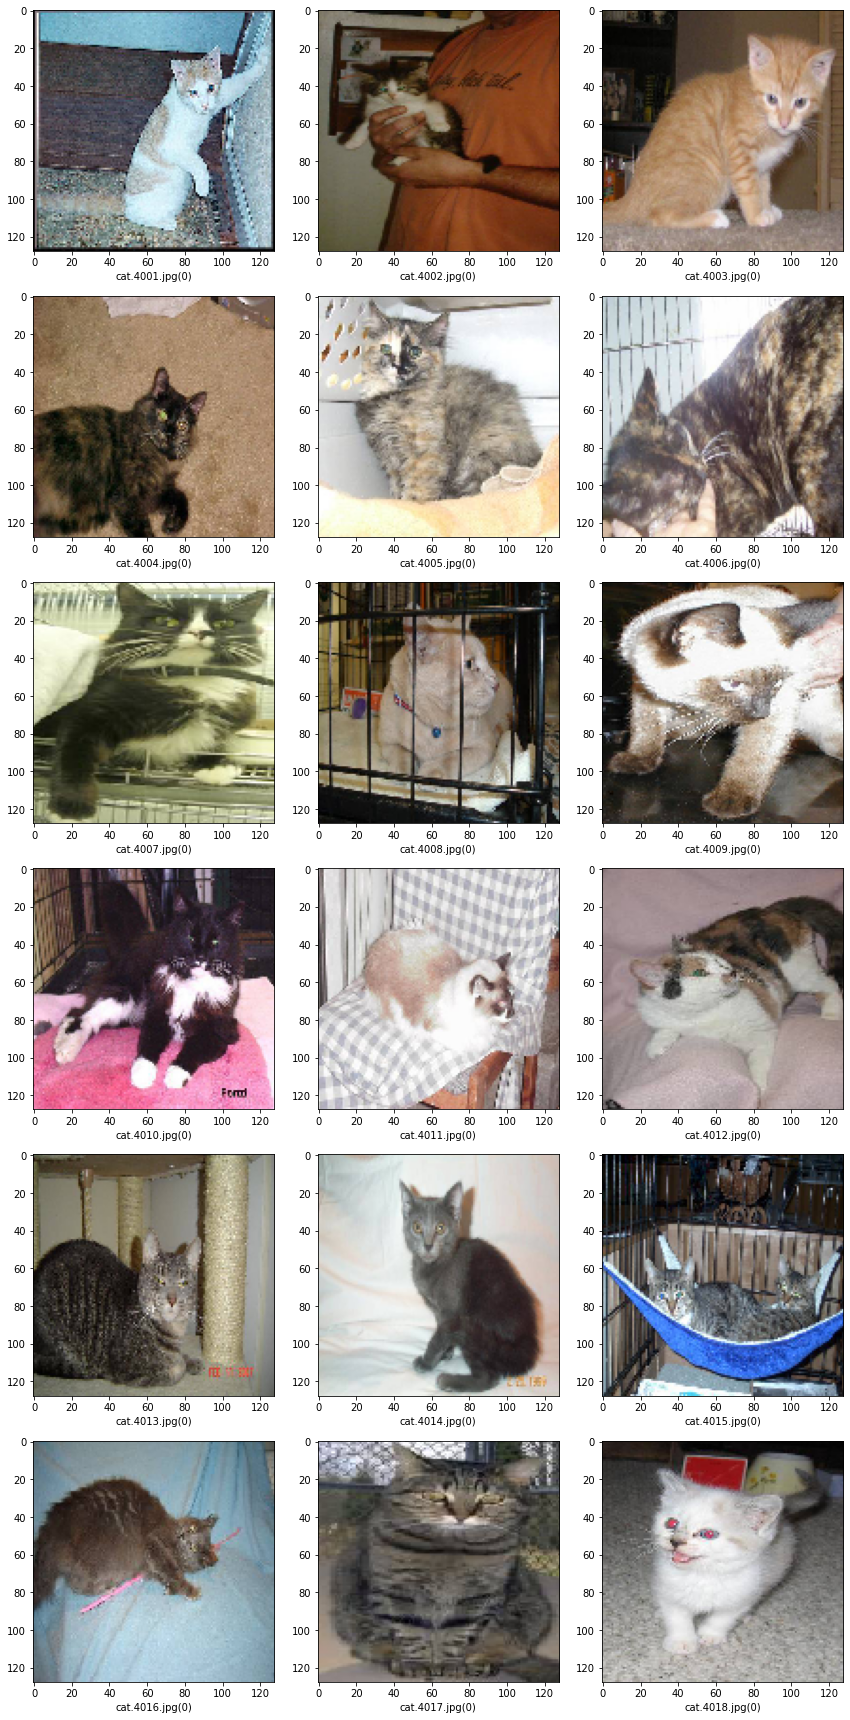

In [18]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("test_set/test_set/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [ ]:
#submission
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)